# Fake News Classification

## Introduction

Fake news articles have become rampant over the years leading to misinformation. Performing an analysis and modelling on news articles will help ensure more accurate news articles are spread. The project will be focused on building models that can help predict whether a news article is real or fake.

## Problem Statement

The manager of our online news agency has tasked me with creating a predictve model that can predict whether a news article is fake or real.

To accomplish this I will build a classifier that can help with the prediction. This will help the agency perform an analysis of submitted articles to help find false news before publication.

## Objectives

My top objectives for modelling will be:

1. Determine the best model to predict fake news.
2. Build a model that can predict fake news with an accuracy 0f 90% or above.


## Data sources

The data for this analysis was obtained from kaggle.

The dataset can be viewed by clicking the following link: <a href="https://www.kaggle.com/competitions/fake-news/data?select=train.csv" target="_blank">Fake News Dataset </a>

## Data Understanding

In this section I will try to understand the dataset before getting into any analysis.

This will involve understanding the shape of the dataset, the columns present and what they represent, the datatypes of the columns and any missing values.

## Explanation of columns in the dataset:

- **id**: This is the unique identifier of the news article.
- **title**: The title of the news article
- **author**: The person who wrote the article.
- **text**: The details of the news article.
- **label**: The output with 1 as real article and 0 as fake article

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

# For traditional ML pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# For deep learning with TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Bidirectional

import warnings
warnings.filterwarnings('ignore')



In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv('train.csv',engine='python', on_bad_lines= 'skip')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.shape

(8164, 5)

- The shape of the dataset is **8164 rows** by **5 columns**.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8164 non-null   int64 
 1   title   7946 non-null   object
 2   author  7389 non-null   object
 3   text    8150 non-null   object
 4   label   8164 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 319.0+ KB


- The columns id, title, author and text are of object data type.

- The text column is of integer data type.

In [6]:
df.isnull().sum()

,0
id,0
title,218
author,775
text,14
label,0


- There are some null values in the dataset. The important column I will be using for modelling is the text column with 14 nulls.

- I will deal with the nulls in the data cleaning section.

In [7]:
df.duplicated().sum()

0

- There are no duplicated values in the dataset.

- I create a copy of the dataset.

In [8]:
train = df.copy()
train.head(2)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


## Data cleaning

In this part I will clean the data to make it good for use in modelling.

- This will involve dealing with missing values and also dropping all unnecessary columns.

In [9]:
# check for distinct values

for col in train.columns:
    distinct_vals = len(train[col].unique())
    print(f"{col}: {distinct_vals} unique values")

id: 8164 unique values
title: 7872 unique values
author: 2349 unique values
text: 8051 unique values
label: 2 unique values


- The label has only 2 unique values.

- The text column has 8051 unique values.

- I drop unnecessary columns that I will not use for analysis and modelling,

In [10]:
train.drop(['id', 'title', 'author'], axis=1, inplace=True)
train.head(3)

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1


In [11]:
train.isna().sum()

,0
text,14
label,0


- There are few nulls, so I will just drop the null values.

In [12]:
train.dropna(inplace=True)

In [13]:
train.isna().sum()

,0
text,0
label,0


In [14]:
train['label'].value_counts()

,count
label,
0,4104
1,4046


- For the class 0 there are 4104 values while for the class 1 there are 4046 values.

In [ ]:
# train = train[train['label'].isin([0, 1])]
# train.shape

In [ ]:
# train.reset_index(drop=True, inplace=True)

## Exploratory data analysis

In this section I will check for the counts and lengths including:
- Character counts
- word count
- mean word length
- mean sentence length.

I will also perform **visualizations** of the most common words and display some bigrams and trigrams

In [15]:
length_sample = len(train['text'][0])
print(f'Length of a sample review: {length_sample}')

Length of a sample review: 4930


In [16]:
train['Length'] = train['text'].str.len()
train.head(10)

,text,label,Length
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930
1,Ever get the feeling your life circles the rou...,0,4160
2,"Why the Truth Might Get You Fired October 29, ...",1,7692
3,Videos 15 Civilians Killed In Single US Airstr...,1,3237
4,Print \nAn Iranian woman has been sentenced to...,1,938
5,"In these trying times, Jackie Mason is the Voi...",0,1192
6,Ever wonder how Britain’s most iconic pop pian...,1,2729
7,"PARIS — France chose an idealistic, traditi...",0,4923
8,Donald J. Trump is scheduled to make a highly ...,0,8177
9,A week before Michael T. Flynn resigned as nat...,0,10261


- Word Count: Number of words in a review

In [17]:
word_count = train['text'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

Word count in a sample review: 820


In [18]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [19]:
train['Word_count'] = train['text'].apply(word_count)
train.head(10)

,text,label,Length,Word_count
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820
1,Ever get the feeling your life circles the rou...,0,4160,710
2,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266
3,Videos 15 Civilians Killed In Single US Airstr...,1,3237,557
4,Print \nAn Iranian woman has been sentenced to...,1,938,154
5,"In these trying times, Jackie Mason is the Voi...",0,1192,203
6,Ever wonder how Britain’s most iconic pop pian...,1,2729,489
7,"PARIS — France chose an idealistic, traditi...",0,4923,822
8,Donald J. Trump is scheduled to make a highly ...,0,8177,1440
9,A week before Michael T. Flynn resigned as nat...,0,10261,1736


- Mean word length: Average length of words

In [20]:
train['mean_word_length'] = train['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
train.head()

,text,label,Length,Word_count,mean_word_length
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820,5.001220
1,Ever get the feeling your life circles the rou...,0,4160,710,4.836620
2,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266,5.059242
3,Videos 15 Civilians Killed In Single US Airstr...,1,3237,557,4.788151
4,Print \nAn Iranian woman has been sentenced to...,1,938,154,5.071429


- Mean sentence length: Average length of the sentences in the review

In [21]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(train['text'][0])])

132.13513513513513

In [22]:
train['mean_sent_length'] = train['text'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
train.head(10)

,text,label,Length,Word_count,mean_word_length,mean_sent_length
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820,5.001220,132.135135
1,Ever get the feeling your life circles the rou...,0,4160,710,4.836620,142.448276
2,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266,5.059242,149.529412
3,Videos 15 Civilians Killed In Single US Airstr...,1,3237,557,4.788151,118.444444
4,Print \nAn Iranian woman has been sentenced to...,1,938,154,5.071429,186.200000
5,"In these trying times, Jackie Mason is the Voi...",0,1192,203,4.862069,65.111111
6,Ever wonder how Britain’s most iconic pop pian...,1,2729,489,4.570552,108.200000
7,"PARIS — France chose an idealistic, traditi...",0,4923,822,4.957421,143.823529
8,Donald J. Trump is scheduled to make a highly ...,0,8177,1440,4.670833,114.183099
9,A week before Michael T. Flynn resigned as nat...,0,10261,1736,4.889977,141.527778


In [23]:
# create a function for box plots
def box_plot(df, col):
    fig, ax = plt.subplots(figsize=(8,7))
    sns.boxplot(y=col, data=df)
    plt.title(f"{col}");

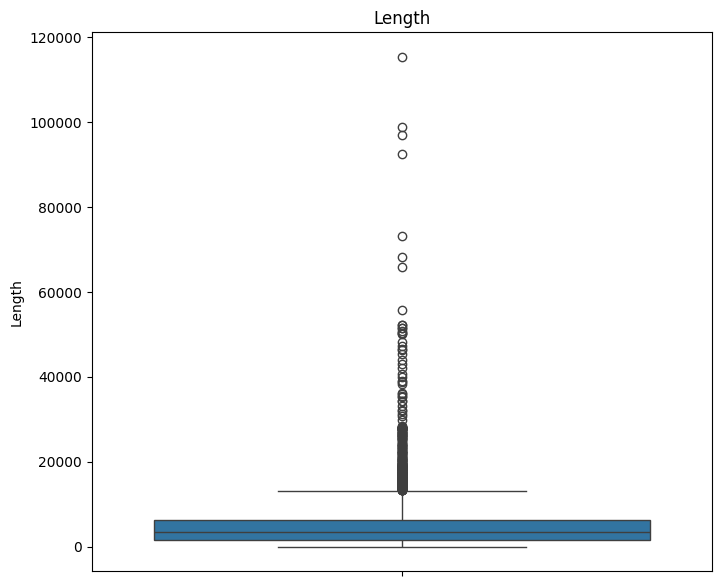

In [24]:
box_plot(train, 'Length')

- An average length of an article is aroung 300.

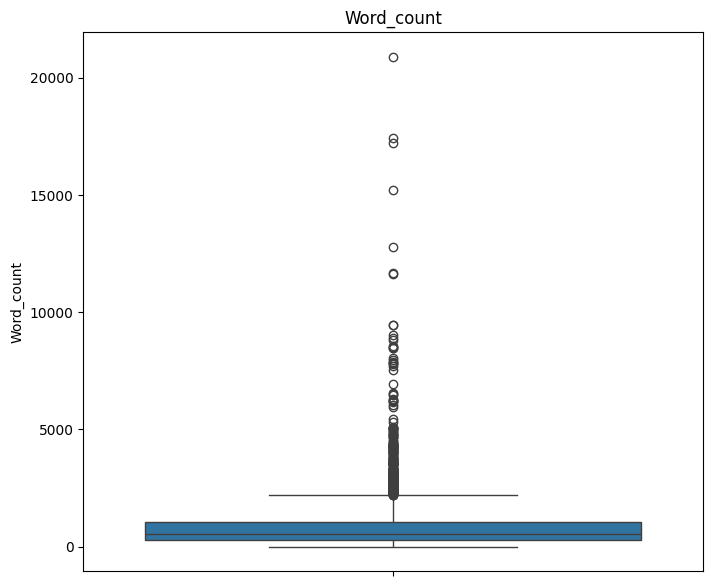

In [25]:
box_plot(train, 'Word_count')

- I can see that most word count is around 500.

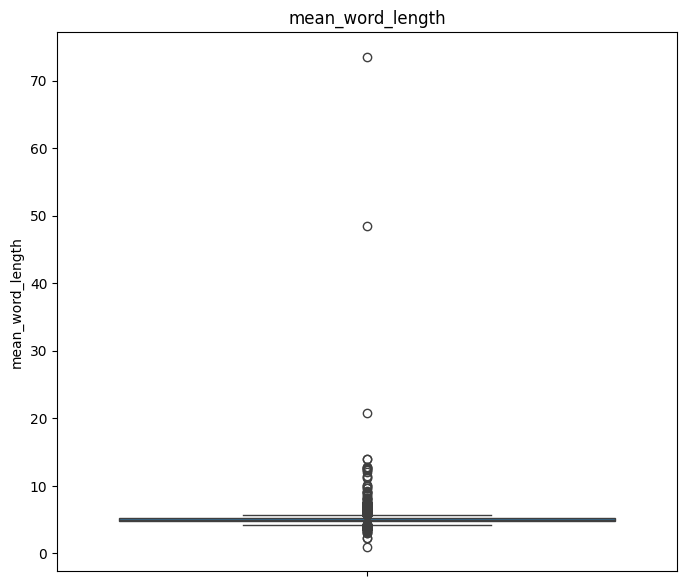

In [26]:
box_plot(train, 'mean_word_length')

- From the box plot most words have a mean length of 5.

## Term Frequency Analysis

Examining the most frequently occuring words is one of the most popular systems of Text analytics. For example, in a sentiment analysis problem, a positive text is bound to have words like 'good', 'great', 'nice', etc. more in number than other words that imply otherwise.

Term Frequencies are more than counts and lenghts, so the first requirement is to preprocess the text

In [27]:
features = train.columns.tolist()[2:]

In [28]:
data = train.drop(features, axis=1)
data.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [29]:
data.shape

(8150, 2)

For Term frequency analysis, it is essential that the text data be preprocessed.

- Lowercase the text
- Remove punctutations
- Stopword removal

In [ ]:
def clean(review):
    # lowercase all the text
    review = review.lower()
    # remove unnecessary characters
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    # join all the words in an article
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [31]:
data['text'] = data['text'].apply(clean)
data.head(10)

,text,label
0,house dem aide didnt even see comeys letter ja...,1
1,ever get feeling life circles roundabout rathe...,0
2,truth might get fired october 29 2016 tension ...,1
3,videos 15 civilians killed single us airstrike...,1
4,print iranian woman sentenced six years prison...,1
5,trying times jackie mason voice reason weeks e...,0
6,ever wonder britains iconic pop pianist gets l...,1
7,paris france chose idealistic traditional cand...,0
8,donald j trump scheduled make highly anticipat...,0
9,week michael flynn resigned national security ...,0


In [ ]:
# create a function to split the articles
def corpus(text):
    text_list = text.split()
    return text_list

In [33]:
data['Review_lists'] = data['text'].apply(corpus)
data.head(10)

,text,label,Review_lists
0,house dem aide didnt even see comeys letter ja...,1,"[house, dem, aide, didnt, even, see, comeys, l..."
1,ever get feeling life circles roundabout rathe...,0,"[ever, get, feeling, life, circles, roundabout..."
2,truth might get fired october 29 2016 tension ...,1,"[truth, might, get, fired, october, 29, 2016, ..."
3,videos 15 civilians killed single us airstrike...,1,"[videos, 15, civilians, killed, single, us, ai..."
4,print iranian woman sentenced six years prison...,1,"[print, iranian, woman, sentenced, six, years,..."
5,trying times jackie mason voice reason weeks e...,0,"[trying, times, jackie, mason, voice, reason, ..."
6,ever wonder britains iconic pop pianist gets l...,1,"[ever, wonder, britains, iconic, pop, pianist,..."
7,paris france chose idealistic traditional cand...,0,"[paris, france, chose, idealistic, traditional..."
8,donald j trump scheduled make highly anticipat...,0,"[donald, j, trump, scheduled, make, highly, an..."
9,week michael flynn resigned national security ...,0,"[week, michael, flynn, resigned, national, sec..."


In [34]:
data.reset_index(drop=True, inplace=True)
data.head()

,text,label,Review_lists
0,house dem aide didnt even see comeys letter ja...,1,"[house, dem, aide, didnt, even, see, comeys, l..."
1,ever get feeling life circles roundabout rathe...,0,"[ever, get, feeling, life, circles, roundabout..."
2,truth might get fired october 29 2016 tension ...,1,"[truth, might, get, fired, october, 29, 2016, ..."
3,videos 15 civilians killed single us airstrike...,1,"[videos, 15, civilians, killed, single, us, ai..."
4,print iranian woman sentenced six years prison...,1,"[print, iranian, woman, sentenced, six, years,..."


In [35]:
corpus = []
for i in trange(data.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += data['Review_lists'][i]
len(corpus)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 8150/8150 [00:00<00:00, 108073.62it/s]


3495607

- The length of the corpus is 3,495,607

In [36]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('said', 31544),
 ('mr', 25995),
 ('trump', 17157),
 ('one', 14773),
 ('would', 14708),
 ('people', 14002),
 ('new', 11678),
 ('us', 10335),
 ('like', 10333),
 ('also', 9782)]

- I can see that the most common 5 words are said, mr, trump, one and would.

In [37]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

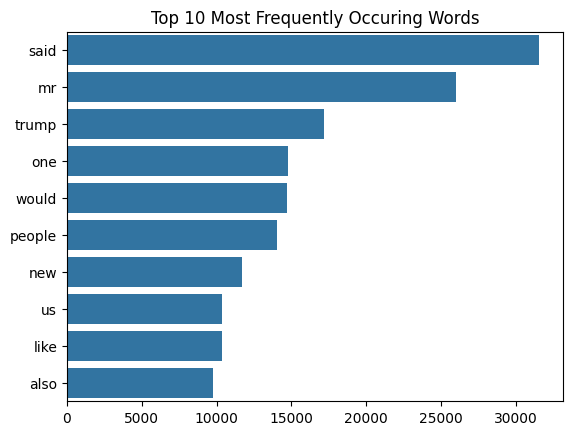

In [38]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

### Most Frequently occuring N_grams

- Here I will create **bi-grams** and **tri-grams** form the data.

- A **bi-gram** is a sequence of **two consecutive words** in a text while a **tri-gram** is a sequence of **three consecutive words** in a text.

- Both bi-grams and tri-grams help capture the relationship between words allowing for **more detailed context** analysis.

In [39]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data['text'])

In [40]:
cv.get_feature_names_out()

array(['00 jobs', '00 one', '000 000', ..., 'zyuganov mild',
       'zyuganov surrendered', 'zzzzs also'], dtype=object)

In [41]:
cv2 = CountVectorizer(ngram_range=(3,3))
trigrams = cv2.fit_transform(data['text'])

In [42]:
cv2.get_feature_names_out()

array(['00 jobs dow', '00 one games', '000 000 000', ...,
       'zyuganov mild church', 'zyuganov surrendered perhaps',
       'zzzzs also emergency'], dtype=object)

- I perform **stemming** on the Review_lists. This will help reduce words to their **root form**.

- Stemming will also help **decrease** the total number of **distinct terms** in the vocabulary. This reduces the dimentionality of the data making it easier to handle for models

In [43]:
# stemming review list
ps = PorterStemmer()

def stem_words(text):
    return [ps.stem(word) for word in text]

data['review_list'] = data['Review_lists'].apply(stem_words)
data.head()

,text,label,Review_lists,review_list
0,house dem aide didnt even see comeys letter ja...,1,"[house, dem, aide, didnt, even, see, comeys, l...","[hous, dem, aid, didnt, even, see, comey, lett..."
1,ever get feeling life circles roundabout rathe...,0,"[ever, get, feeling, life, circles, roundabout...","[ever, get, feel, life, circl, roundabout, rat..."
2,truth might get fired october 29 2016 tension ...,1,"[truth, might, get, fired, october, 29, 2016, ...","[truth, might, get, fire, octob, 29, 2016, ten..."
3,videos 15 civilians killed single us airstrike...,1,"[videos, 15, civilians, killed, single, us, ai...","[video, 15, civilian, kill, singl, us, airstri..."
4,print iranian woman sentenced six years prison...,1,"[print, iranian, woman, sentenced, six, years,...","[print, iranian, woman, sentenc, six, year, pr..."


In [44]:
# Convert token lists to strings
data["joined_preprocessed_text"] = data["review_list"].str.join(" ")

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(
    data["joined_preprocessed_text"], data.label, test_size=0.3, random_state=42)

X_train

,joined_preprocessed_text
2045,daili mail octob 27 2016 entertain firm fight ...
2937,hillari clinton declar democrat parti presiden...
462,cnn outlet high dudgeon friday afternoon sever...
1956,11 depress econom realiti donald trump inherit...
2445,polic attack arrest peac protest dakota access...
...,...
5226,migrant crisi disclaim daili stormer oppos vio...
5390,sent thursday octob 1 2015 720 pm robbi mook r...
860,aboard wavertre kill van kull 131 year sinc ca...
7603,justin gardner controversi dakota access pipel...


- I create a pipeline using tfidfVectorizer and a classifier as multinomialNB

## MultinomialNB model

In [48]:
# We'll use a pipeline that vectorizes the text with TF-IDF and then trains a MultinomialNB classifier.
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

In [49]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [50]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
print("\nML Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))


ML Model Evaluation:
Accuracy: 0.8339468302658487


In [51]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86      1230
           1       0.99      0.68      0.80      1215

    accuracy                           0.83      2445
   macro avg       0.87      0.83      0.83      2445
weighted avg       0.87      0.83      0.83      2445



- I see an accuracy score of 83%. I will perform gridsearch to help see if there will be an improvement in the performance of the model.

- Create a grid search for the multinomialNB to help tune the hyperparameters.

In [52]:
# Define a grid of hyperparameters to search over
param_grid = {
    "tfidf__max_df": [0.9, 0.95],
    "tfidf__min_df": [1, 2],
    #"tfidf__ngram_range": [(1, 1), (1, 2)],
    "clf__alpha": [0.1, 1.0, 10.0]
}

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)

In [53]:
# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 1.0, 10.0],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__min_df': [1, 2]},
             verbose=1)

- Check for the best parameters and the best cross validation score

In [54]:
# Output the best parameters and best cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'clf__alpha': 0.1, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2}
Best Cross-Validation Score: 0.9095529259140641


In [55]:
# Evaluate the best estimator on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Set Score:", test_score)

Test Set Score: 0.9165644171779141


In [56]:
# Generate predictions and output the classification report
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1230
           1       0.96      0.87      0.91      1215

    accuracy                           0.92      2445
   macro avg       0.92      0.92      0.92      2445
weighted avg       0.92      0.92      0.92      2445



## Per-Class Metrics

### Precision:

**Definition**: The ratio of true positive predictions to the total predicted positives for that class. It tells you, “Of all the instances the model labeled as a given class, how many were actually that class?”

### For Class 0:

Precision = 0.88: This means that when the model predicted class 0, 88% of those predictions were correct.

For Class 1:
Precision = 0.96: This indicates that when the model predicted class 1, 96% of those predictions were correct.

### Recall:

**Definition**: The ratio of true positive predictions to the total actual instances of that class. It answers, “Of all the actual instances of a class, how many did the model correctly identify?”

For Class 0:

Recall = 0.96: Out of all actual class 0 instances, 96% were correctly predicted.
For Class 1:

Recall = 0.87: Out of all actual class 1 instances, 87% were correctly identified.

### Overall Performance:

With an accuracy of 92%, the model performs well overall.

In [57]:
data.head()

,text,label,Review_lists,review_list,joined_preprocessed_text
0,house dem aide didnt even see comeys letter ja...,1,"[house, dem, aide, didnt, even, see, comeys, l...","[hous, dem, aid, didnt, even, see, comey, lett...",hous dem aid didnt even see comey letter jason...
1,ever get feeling life circles roundabout rathe...,0,"[ever, get, feeling, life, circles, roundabout...","[ever, get, feel, life, circl, roundabout, rat...",ever get feel life circl roundabout rather hea...
2,truth might get fired october 29 2016 tension ...,1,"[truth, might, get, fired, october, 29, 2016, ...","[truth, might, get, fire, octob, 29, 2016, ten...",truth might get fire octob 29 2016 tension int...
3,videos 15 civilians killed single us airstrike...,1,"[videos, 15, civilians, killed, single, us, ai...","[video, 15, civilian, kill, singl, us, airstri...",video 15 civilian kill singl us airstrik ident...
4,print iranian woman sentenced six years prison...,1,"[print, iranian, woman, sentenced, six, years,...","[print, iranian, woman, sentenc, six, year, pr...",print iranian woman sentenc six year prison ir...


In [58]:
data['joined_preprocessed_text'][1]

'ever get feel life circl roundabout rather head straight line toward intend destin hillari clinton remain big woman campu leafi liber wellesley massachusett everywher els vote like inaugur dress remaind day way miss havisham forev wore wed dress speak great expect hillari rodham overflow 48 year ago first address wellesley graduat class presid colleg inform gather 1969 student need debat far could ascertain spokesman kind like democrat primari 2016 minu term unknown even seven sister school glad miss adam made clear speak today us 400 us miss rodham told classmat appoint edger bergen charli mccarthi mortim snerd attend bespectacl granni glass award matronli wisdom least john lennon wisdom took issu previou speaker despit becom first win elect seat u senat sinc reconstruct edward brook came critic call empathi goal protestor critic tactic though clinton senior thesi saul alinski lament black power demagogu elitist arrog repress intoler within new left similar word come republican neces

- Create a corpus list which will contain all the articles.

In [59]:
# Create an empty corpus list
articles = []

# Append each text entry from the 'joined_preprocessed_text' column to the corpus using a loop.
for entry in data['joined_preprocessed_text']:
    articles.append(entry)

- Check the first article

In [60]:
articles[1]

'ever get feel life circl roundabout rather head straight line toward intend destin hillari clinton remain big woman campu leafi liber wellesley massachusett everywher els vote like inaugur dress remaind day way miss havisham forev wore wed dress speak great expect hillari rodham overflow 48 year ago first address wellesley graduat class presid colleg inform gather 1969 student need debat far could ascertain spokesman kind like democrat primari 2016 minu term unknown even seven sister school glad miss adam made clear speak today us 400 us miss rodham told classmat appoint edger bergen charli mccarthi mortim snerd attend bespectacl granni glass award matronli wisdom least john lennon wisdom took issu previou speaker despit becom first win elect seat u senat sinc reconstruct edward brook came critic call empathi goal protestor critic tactic though clinton senior thesi saul alinski lament black power demagogu elitist arrog repress intoler within new left similar word come republican neces

- Create a vocabulary size which is the total number of **unique words** that the model will recognize and process.

## LSTM Model

In [61]:
### Vocabulary size
voc_size=5000

- Perform onehot encoding on the words of each article

In [62]:
onehot_repr=[one_hot(words,voc_size)for words in articles]
#onehot_repr

In [63]:
len(onehot_repr[1])

379

## Embedding Representation

- Create a **sentence length** of 50 which defines the **maximum length** of a sequence for each document in the dataset. Neural networks expect input data to have a consistent shape. Since each document may have different number of words, you must pad or truncate the sequences to ensure they all have the same length.

- I then use **pad_sequences** to standardize the length of sequences by adding padding to them (if they are too short) or truncating them (if they are too long).

In [64]:
sent_length=50
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
print(embedded_docs)

[[2542 1452 4749 ... 2083 2034 3330]
 [1169  128 2853 ... 4904 1840 1546]
 [2786 1249 3482 ... 1375 3326 2977]
 ...
 [1115 4031 3369 ...    0    0    0]
 [3508 4501 2241 ... 3696  146 4470]
 [3938 4247  647 ... 3049 3635 2074]]


In [65]:
embedded_docs[1]

array([1169,  128, 2853, 3764, 1746, 4745,  572, 4220, 4653,  572, 1295,
       2885, 3637, 2099, 4472, 3442, 1746, 3144, 3574, 4404, 2986,  640,
        292, 4514,  640, 4817, 1333,  572, 4626, 1343, 2152, 1074, 2137,
       3382, 3299, 1467, 4294, 2372,  454,  440,  601,  746, 3973, 3125,
       4371, 2561,  601, 4904, 1840, 1546], dtype=int32)

In [66]:
## Creating model
# Define the number of dimensions for the embedding vectors.
# This is the size of the vector that will represent each word.
embedding_vector_features= 40

# Initialize a Sequential model
model=Sequential()

# Add an Embedding layer.
model.add(Embedding(input_dim= voc_size,
                    output_dim= embedding_vector_features,
                    input_length=sent_length))

# Add an LSTM layer with 100 units.
# LSTM (Long Short-Term Memory) helps capture temporal dependencies in sequential data.
model.add(LSTM(100))

# Add a Dense layer with a single neuron.
# The 'sigmoid' activation function is used for binary classification.
model.add(Dense(1, activation='sigmoid'))

# Compile the model.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.build(input_shape=(None, sent_length))
# Print the model summary to see the architecture and number of parameters.
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          56,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256,501 (1001.96 KB)

 Trainable params: 256,501 (1001.96 KB)

 Non-trainable params: 0 (0.00 B)

None


- From above I see that:

- **Total params**: 256,501

> This represents the sum of all the parameters in the model. The total number of parameters across all layers is 256,501, which > includes the embedding layer (200,000), the LSTM layer (56,400), and the dense layer (101).

- **Trainable params**: 256,501

> All parameters in this model are trainable, meaning they will be updated during the training process.

- **Non-trainable params**: 0

> There are no non-trainable parameters in this model.


In [67]:
len(embedded_docs)

8150

- Convert the X_final and y_final to arrays, which will allow for faster training.

- Neural networks also rely on matrix and vector operations for forward and backward propagation.

In [68]:
X_final=np.array(embedded_docs)
y_final=np.array(data['label'])

In [69]:
X_final.shape,y_final.shape

((8150, 50), (8150,))

- Perform train test split using a random state of 42 and a test size of 30%

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

In [ ]:
### Training
model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=10,
          batch_size=64)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6750 - loss: 0.5568 - val_accuracy: 0.8483 - val_loss: 0.3727
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9150 - loss: 0.2433 - val_accuracy: 0.8748 - val_loss: 0.3251
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9604 - loss: 0.1323 - val_accuracy: 0.8744 - val_loss: 0.3216
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9802 - loss: 0.0834 - val_accuracy: 0.8638 - val_loss: 0.3788
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9897 - loss: 0.0429 - val_accuracy: 0.8556 - val_loss: 0.5305
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9898 - loss: 0.0397 - val_accuracy: 0.8552 - val_loss: 0.5653
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9934 - loss: 0.0328 - val_accuracy: 0.8528 - val_loss: 0.6514
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9955 - loss: 0.0236 - val_accuracy: 0.8609 - val_lo

- Perform predictions using the test set.

In [78]:
y_pred=model.predict(X_test)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [79]:
y_pred

array([[0.5014697 ],
       [0.49685726],
       [0.4980048 ],
       ...,
       [0.500008  ],
       [0.5007762 ],
       [0.4994318 ]], dtype=float32)

In [80]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("\nTest Loss:", loss)
print("Test Accuracy:", accuracy)


Test Loss: 0.692518413066864
Test Accuracy: 0.546012282371521


- A **test loss** of 0.6925 indicates that the model's predictions are not very accurate, and it's still quite far from optimal.

- An **accuracy** of 54.60% is quite low, which suggests the model has some room for improvement. It's better than random guessing but not by much.

## Bidirectional LSTM model

In [ ]:
## Creating bidirectional model
embedding_vector_features=40
model2=Sequential()

model2.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))

model2.add(Bidirectional(LSTM(100)))

model2.add(Dense(1,activation='sigmoid'))

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.build(input_shape=(None, sent_length))
print(model2.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200)                 │         112,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 313,001 (1.19 MB)

 Trainable params: 313,001 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

None


- From above I see that:

- **Total params**: 313,001

> This represents the sum of all the parameters in the model. The total number of parameters across all layers is 313,001, which > includes the embedding layer (200,000), the bidirectional layer (112,800), and the dense layer (201).

- **Trainable params**: 313,001

> All parameters in this model are trainable, meaning they will be updated during the training process.

- **Non-trainable params**: 0

> There are no non-trainable parameters in this model. Non-trainable parameters can occur if, for example, pre-trained weights are used, but in this case, everything is trainable.


- I then train the model using a batch size of 32 and 10 epochs

In [86]:
## Model Training
model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=32)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7367 - loss: 0.5117 - val_accuracy: 0.8875 - val_loss: 0.2859
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9320 - loss: 0.1867 - val_accuracy: 0.8601 - val_loss: 0.3266
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9666 - loss: 0.1122 - val_accuracy: 0.8466 - val_loss: 0.3823
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9672 - loss: 0.0954 - val_accuracy: 0.8650 - val_loss: 0.4183
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9816 - loss: 0.0640 - val_accuracy: 0.8675 - val_loss: 0.5629
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9820 - loss: 0.0482 - val_accuracy: 0.8622 - val_loss: 0.4436
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9884 - loss: 0.0375 - val_accuracy: 0.8519 - val_loss: 0.5729
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9926 - loss: 0.0287 - val_accu

- Perform **predictions** on the test set.

In [87]:
y_pred2=model2.predict(X_test)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


- Evaluate the model on the test set to see how the model is performing.

In [88]:
# Evaluate the model on the test set
loss, accuracy = model2.evaluate(X_test, y_test, verbose=0)
print("\nTest Loss:", loss)
print("Test Accuracy:", accuracy)


Test Loss: 0.6352420449256897
Test Accuracy: 0.86094069480896


- I see an improved accuracy score of 86% using bidirectional LSTM. This is a much better performance compared to the normal LSTm model.

- Despite it performing well, the multinomialNB model performs better with a 92% accuracy score.

## Conclusion

- The analysis and modelling employed a **multinomialNB** model, **long short-term memory** and **bidirectional LSTM** model. The model was trained and evaluated on a dataset of 8000 rows.

- The **best performing** model was the **multinomialNB**. The model achieved an accuracy of 92% with a precision of .88 for class 0 and .96 for class 1. It was also able to recall 96% of class 0 and 87% of class 1 correctly. The relatively high accuracy and balanced performance on both classes indicate that the model is well tuned and robust.

## Recommendations

- Despite the model achieving a good accuracy score of 92%, **more data** should be collected to help improve the model.

- Consider **transformer-based models** trained on vast datasets to improve performance over more traditional models.

## Suggestions for future improvement

- Implement **advanced models** such as BERT (Bidirectional Encoder Representations from Transformers) for context understanding and content validation.

- Build **knowledge graphs** from trusted databases (e.g., Wikipedia) to validate facts mentioned in articles and verify claims in real time.

- Implement **sentiment analysis** to detect patterns in text that are more common in fake news (such extreme opinions).